# 14.5 - 14.8 畳み込みﾆｭｰﾗﾙﾈｯﾄﾜｰｸを使った深層ｺﾝﾋﾟｭｰﾀﾋﾞｼﾞｮﾝ

## 今回の目的
・Kerasを使ったResNet-34CNNの実装<br>
・Kerasで事前学習済みモデルを使う方法<br>
・前学習済みモデルを使った転移学習<br>
・画像の分類と位置特定<br>

### セットアップ

In [1]:
import numpy as np
from functools import partial
from IPython.display import Image
from sklearn.datasets import load_sample_images
import tensorflow as tf

In [2]:
#一度最新版がインストールされているかチェックしてください！
# This project requires Python 3.7 or above
import sys
assert sys.version_info >= (3, 7)

# It also requires Scikit-Learn ≥ 1.0.1:
from packaging import version
import sklearn

In [3]:
print('sklearn', sklearn.__version__)
#2021年9月24日にscikit-learn 1.0がリリース

sklearn 1.1.3


In [4]:
assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

In [5]:
#And TensorFlow ≥ 2.8:
import tensorflow as tf

In [6]:
print('TensorFlow', tf.__version__)
#22年2月頃リリース？

TensorFlow 2.10.0


In [7]:
assert version.parse(tf.__version__) >= version.parse("2.8.0")

In [8]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

## 14.5　Kerasを使ったResNet-34CNNの実装

## 復習

<b>ResNetとは？</b>

**デグレーデーション（Degredation）問題**<br>
モデルを深くする方がかえって制度が落ちていく現象。<br>

これの問題を解消するために考案されたのがResNetである。<br>
その特徴を一言で言えば**恒等写像を学習のスタートラインにしたモデル**である。

<b>ResNetのポイント</b>
* 残差ユニット(residual unit)を多数スタックする
    - スキップ接続（ショートカット接続）を使っていくつかの層の計算結果に下位の入力をそのまま加える。
    - これにより各残差ユニットは"（ターゲットとなる関数） - 入力値"を予測することになる。この学習を残差学習という。
    - 各層のパラメータは0に近い値で初期化するため、各残差ユニットは**恒等写像で初期化されている**と考えることもできる。<br>
    - 各残差ユニットではバッチ正則化、ReLU関数、3×3フィルター（ストライド幅1、sameパディング）2つのConv層を重ねている。（入力を足すためデータサイズは入力と同じにする）

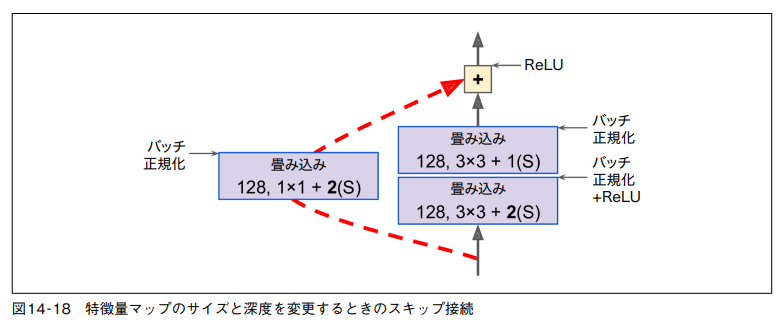

In [9]:
### アーキテクチャ
Image("./fig/ResNet_resize_input.png")

## ReSidualUnit層

コンストラクタでは、必要な層をすべて作っている。</br>
メイン階層は図14-18の右側で、図の左側はスキップ層である（ストライドが1よりも大きいときだけ作られる)｡</br>

参考ページ
https://qiita.com/kenmaro/items/008051dae0bf0ad718cb

In [10]:
DefaultConv2D = partial(tf.keras.layers.Conv2D, kernel_size=3, strides=1,
                        padding="same", kernel_initializer="he_normal",
                        use_bias=False)

class ResidualUnit(tf.keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = tf.keras.activations.get(activation)
        self.main_layers = [
            DefaultConv2D(filters, strides=strides),
            tf.keras.layers.BatchNormalization(),
            self.activation,
            DefaultConv2D(filters),
            tf.keras.layers.BatchNormalization()
        ]
        self.skip_layers = [] #スキップ階層　stridesが1より大きいの場合適用
        if strides > 1:
            self.skip_layers = [
                DefaultConv2D(filters, kernel_size=1, strides=strides),
                tf.keras.layers.BatchNormalization()
            ]

#call()メソッドでは、入力をメイン階層とスキップ階層(ある場合）に送り、両方の出力を加算して活性化関数を適用する。
    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)

## ResNet34(34層を重ねたResNet)


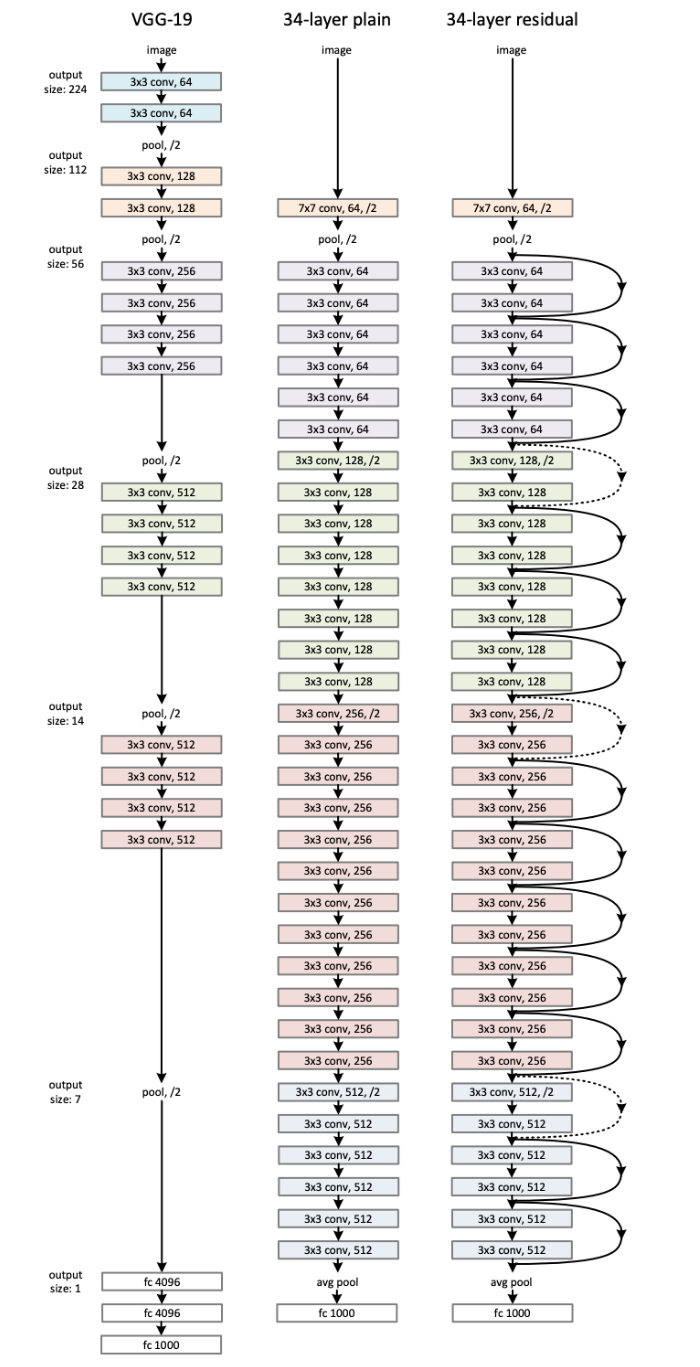

In [11]:
Image("./fig/ResNet-34.jpg")

In [12]:
model = tf.keras.Sequential([
    DefaultConv2D(64, kernel_size=7, strides=2, input_shape=[224, 224, 3]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding="same"),
])

#ResidualUnit層を追加するループ
prev_filters = 64
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3: #最初の3個のRUは64個のフィルタ。次の4個のRUは128個のフィルタを持つ。
    strides = 1 if filters == prev_filters else 2            #フィルタが前のRUと同じならストライドを1、そうでなければストライドを2
    model.add(ResidualUnit(filters, strides=strides))        #ResidualUnitを追加
    prev_filters = filters                                   #prev_filtersを更新

model.add(tf.keras.layers.GlobalAvgPool2D())
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(10, activation="softmax"))

## 14.6　Kerasで事前学習済みモデルを使う方法

一般に、GoogLeNetやResNetのような標準モデルはkeras.applicationsパッケージに1行で作れる形で含まれているので、手作業で作る必要はない。</br>
たとえば、ImageNetで事前学習済みのResNet50モデルは、次のコードでロードできる。

In [13]:
model = tf.keras.applications.ResNet50(weights="imagenet")

**ResNet50モデルは、224×224ピクセルの画像を想定**しているので（ほかのモデルは299×299など、別のサイズを想定）</br>
そこでTensorFlowのtf.image.resize()関数を使って、以前ロードした画像のサイズを変更する


※tf.image.resize()はアスペクト比を変えてしまう。</br>
それが問題ならサイズ変更する前に適切なアスペクト比になるように画像を切り取ろう。</br>
tf.image.crop_and_resize()を使えば、切り取りとサイズ変更をまとめて実行可能。らしい。

In [14]:
#サンプルイメージ読み込み！
images = load_sample_images()["images"]
images_resized = tf.keras.layers.Resizing(height=224, width=224,
                                          crop_to_aspect_ratio=True)(images)

In [15]:
inputs = tf.keras.applications.resnet50.preprocess_input(images_resized)

In [16]:
Y_proba = model.predict(inputs)
Y_proba.shape

1/1 [==============================] - 1s 1s/step


(2, 1000)

In [17]:
top_K = tf.keras.applications.resnet50.decode_predictions(Y_proba, top=3)
for image_index in range(len(images)):
    print(f"Image #{image_index}")
    for class_id, name, y_proba in top_K[image_index]:
        print(f"  {class_id} - {name:12s} {y_proba:.2%}")

Image #0
  n03877845 - palace       54.69%
  n03781244 - monastery    24.72%
  n02825657 - bell_cote    18.55%
Image #1
  n04522168 - vase         32.66%
  n11939491 - daisy        17.81%
  n03530642 - honeycomb    12.06%


palace⇒宮殿</br>
monastery⇒修道院</br>
bell_cote⇒鐘を雨風から守る小屋</br>

vace⇒花瓶</br>
daisy⇒デイジー</br>
honeycomb⇒ハチの巣</br>

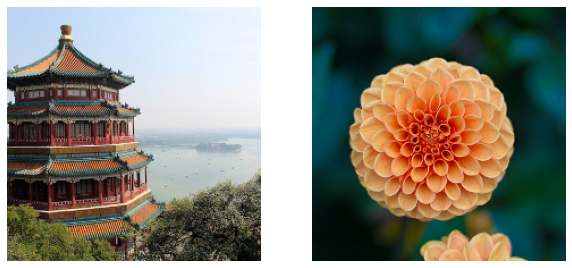

In [18]:
# extra code – displays the cropped and resized images

plt.figure(figsize=(10, 6))
for idx in (0, 1):
    plt.subplot(1, 2, idx + 1)
    plt.imshow(images_resized[idx] / 255)
    plt.axis("off")

plt.show()

モデルが1,000個ものクラスから正しいクラスを選ばなければならないことを考えれば、</br>
これはかなり優れた結果である。らしい。</br>

ちなみに・・・</br>
keras.applicationsには、ResNetの複数のバリアント、Inception-v3やXceptionなどのGoogLeNetのバリアント、</br>
VGGNetのバリアント、MobileNetとMobileNet2 (モバイルアプリ用の軽量モデル）などのビジョンモデルが含まれている。

**ただ、ImageNetの一部にない画像クラスを対象として画像分類器を使いたいときにはどうすればよいのだろうか？</br>
そのようなときでも、転移学習をすれば事前学習済みモデルを活用できる。**

## 14.7　前学習済みモデルを使った転移学習

画像分類器を作りたいけれども十分な量の訓練データが集まらない場合には、</br>
11章で説明したように、事前学習済みモデルの階層を再利用するとよいことが多い。</br>
たとえば、事前学習済みのXceptionモデルを使って花の画像を分類するモデルを訓練してみよう！

In [19]:
#おそらくダウンロードしていないから追加
#pip install tensorflow_datasets

In [20]:
import tensorflow_datasets as tfds

dataset, info = tfds.load("tf_flowers", as_supervised=True, with_info=True)
dataset_size = info.splits["train"].num_examples
class_names = info.features["label"].names
n_classes = info.features["label"].num_classes

In [21]:
dataset_size

3670

In [22]:
class_names

['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']

In [23]:
n_classes

5

In [24]:
#残念ながら、"train"データセットしかなく、テストセットや検証セットはないので、訓練セットを分割しなければならない。
test_set_raw, valid_set_raw, train_set_raw = tfds.load(
    "tf_flowers",
    split=["train[:10%]", "train[10%:25%]", "train[25%:]"],
    as_supervised=True)

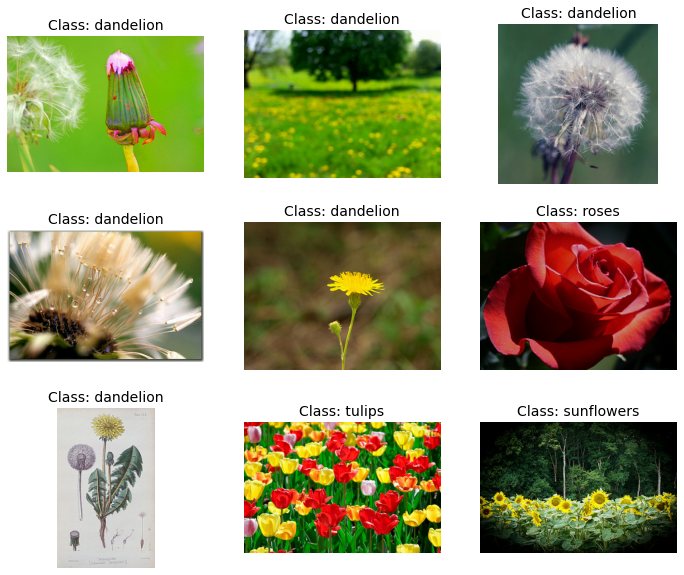

In [25]:
# 検証セットの最初の 9 つの画像を表示
plt.figure(figsize=(12, 10))
index = 0
for image, label in valid_set_raw.take(9):
    index += 1
    plt.subplot(3, 3, index)
    plt.imshow(image)
    plt.title(f"Class: {class_names[label]}")
    plt.axis("off")

plt.show()

In [26]:
tf.keras.backend.clear_session()  # extra code – resets layer name counter

batch_size = 32

#画像の前処理
preprocess = tf.keras.Sequential([
    tf.keras.layers.Resizing(height=224, width=224, crop_to_aspect_ratio=True),
    tf.keras.layers.Lambda(tf.keras.applications.xception.preprocess_input)
])

train_set = train_set_raw.map(lambda X, y: (preprocess(X), y))
train_set = train_set.shuffle(1000, seed=42).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(lambda X, y: (preprocess(X), y)).batch(batch_size)
test_set = test_set_raw.map(lambda X, y: (preprocess(X), y)).batch(batch_size)

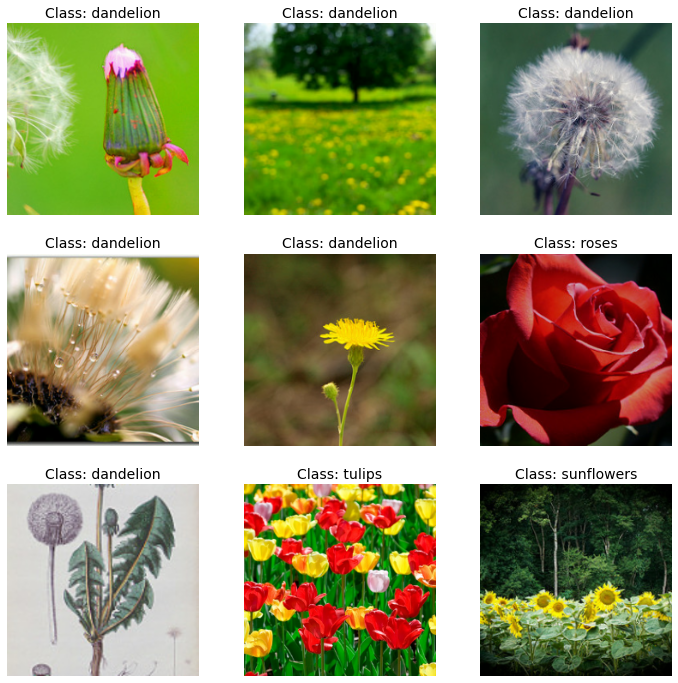

In [27]:
# valid_set の最初のバッチの最初の 9 つの画像を表示

plt.figure(figsize=(12, 12))
for X_batch, y_batch in valid_set.take(1):
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        plt.imshow((X_batch[index] + 1) / 2)  # rescale to 0–1 for imshow()
        plt.title(f"Class: {class_names[y_batch[index]]}")
        plt.axis("off")

plt.show()

In [28]:
#データ拡張
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip(mode="horizontal", seed=42),
    tf.keras.layers.RandomRotation(factor=0.05, seed=42),
    tf.keras.layers.RandomContrast(factor=0.2, seed=42)
])

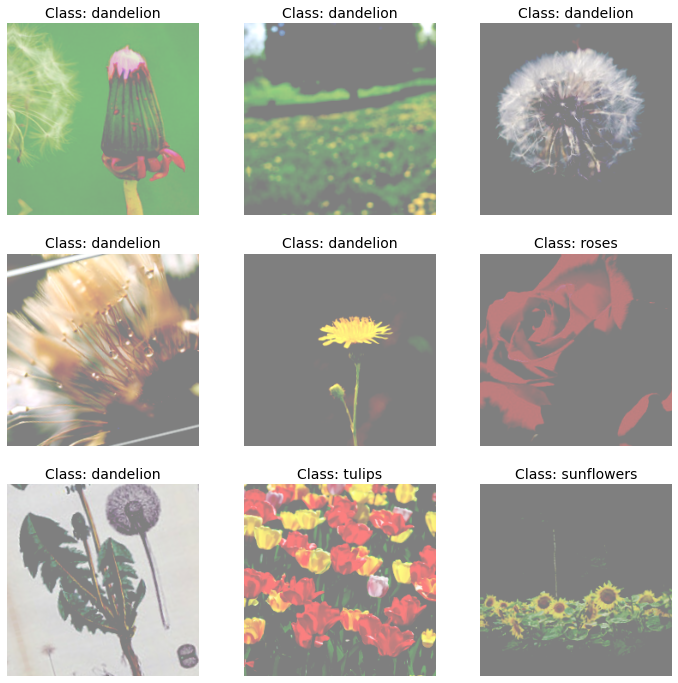

In [29]:
#データ拡張後、同じ最初の 9 つの画像を表示

plt.figure(figsize=(12, 12))
for X_batch, y_batch in valid_set.take(1):
    X_batch_augmented = data_augmentation(X_batch, training=True)
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        # We must rescale the images to the 0-1 range for imshow(), and also
        # clip the result to that range, because data augmentation may
        # make some values go out of bounds (e.g., RandomContrast in this case).
        plt.imshow(np.clip((X_batch_augmented[index] + 1) / 2, 0, 1))
        plt.title(f"Class: {class_names[y_batch[index]]}")
        plt.axis("off")

plt.show()

In [30]:
tf.random.set_seed(42)  #再現性の確保

#ImageNetで事前学習したXceptionモデルをロードする。
#ただし、include_top=Falseを指定してネットワークの最上位を取り除く。(グローバル平均プーリング層と全結合出力層を排除)
base_model = tf.keras.applications.xception.Xception(weights="imagenet",
                                                     include_top=False) 

#ベースモデルの出力に基づく独自のグローバル平均プーリング層を追加
avg = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)

#クラスごとに1ユニットのソフトマックス活性化関数付きの全結合出力層を追加
output = tf.keras.layers.Dense(n_classes, activation="softmax")(avg)

model = tf.keras.Model(inputs=base_model.input, outputs=output)

TensorFlow, Kerasのレイヤーやモデルのtrainable属性で、そのレイヤーまたはモデルを訓練（学習）するかしないか、</br>
すなわち、訓練時にパラメータ（カーネルの重みやバイアスなど）を更新するかどうかを設定できる。

レイヤーやモデルを訓練対象から除外することを「freeze（凍結）」、</br>
freezeしたレイヤーやモデルを再び訓練対象とすることを「Unfreeze（解凍、凍結解除）」と呼ぶ。

今回、base_modelオブジェクトではなく、ベースモデルの階層を直接使っているので、</br>
base_model.trainable=Falseを実行しても無意味らしい。

In [31]:
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
#モデルのコンパイルをして訓練開始
optimizer = tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set, validation_data=valid_set, epochs=1) #重すぎるからepoch5⇒1に変更

60/86 [===================>..........] - ETA: 59s - loss: 0.7685 - accuracy: 0.7901 

GPUがなければ、訓練にはとても長い時間がかかるだろう。←かかりました。。。</br>
GPUがある場合には、GPUランタイム(なんと無料だ)を指定したColabで、この章のJupyterノートブックを実行してみよう。</br>
https://github.com/ageron/handson-ml2
の説明を参照のこと。

モデルを数エポック訓練すると、検証セットを対象とする正解率が75%から80%程度に達し、そこで進歩が止まる。</br>
これは上位層が十分訓練されたというサインであり、全階層（上位層だけでもよい）の凍結を解除して訓練を続行する</br>
（階層の凍結、解凍をしたときには、モデルをコンパイルすることを忘れないように)。</br>
今度は、事前学習済みの重みを破壊しないように、学習率を大幅に下げる。

In [ ]:
for indices in zip(range(33), range(33, 66), range(66, 99), range(99, 132)):
    for idx in indices:
        print(f"{idx:3}: {base_model.layers[idx].name:22}", end="")
    print()

In [ ]:
#全階層の凍結を解除・・・そして訓練
for layer in base_model.layers[56:]:
    layer.trainable = True

optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set, validation_data=valid_set, epochs=1)

少し時間がかかるが、このモデルはテストセットの正解率が95%前後になるはず。らしい</br>
ここから驚異的な成績を収める画像分類器の訓練がスタートする。</br>
しかし、コンピュータビジョンは分類だけではない。</br>
たとえば、写真のどこに花があるかを知りたい場合にはどうすればよいだろうか。次はこれを見ていこう。

## 14.8　分類と位置特定

画像内での物体の位置の特定は、10章で説明したように回帰タスクとして表現できる。</br>

<Pythonを用いたデータ分析における３種類のタスクイメージ></br>
回帰タスク：株価、医療費、来院数など数値を予測する。</br>
分類タスク：グループに属するor属さないを予測する。</br>
レコメンデーション：ユーザーが購入しそうな商品やクリックしそうな広告を予測する。</br>

物体を囲むバウンデイング（境界）ボックスの予測では、</br>
物体の幅と高さに加え、物体の中心の位置を予測するのが一般的な方法である。</br>
つまり、4個のメンバーを予測するということだ。モデルを大きく変更する必要はない｡</br>
4個のユニットを持つ第2の全結合層を追加し（一般に上位のグローバル平均プーリング層の上に)、MSE損失関数で訓練すればよい。</br>
※MSE:平均二乗誤差

In [ ]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
base_model = tf.keras.applications.xception.Xception(weights="imagenet",
                                                     include_top=False)

avg = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
class_output = tf.keras.layers.Dense(n_classes, activation="softmax")(avg)
loc_output = tf.keras.layers.Dense(4)(avg)

model = tf.keras.Model(inputs=base_model.input,
                       outputs=[class_output, loc_output])

model.compile(loss=["sparse_categorical_crossentropy", "mse"],
              loss_weights=[0.8, 0.2],  # 何を重要視するかで変化
              optimizer=optimizer, metrics=["accuracy"])

### バウンデイングボックスをつけたデータがない苦悩
しかし、ここで問題にぶつかる。花のデータセットは、花のまわりにバウンデイングボックスを付けてはいないのである。</br>
私たちが自分でボックスを追加しなければならない。</br>
これは、機械学習プロジェクトのなかでももっとも難しく、コストがかかる部分になることが多い。</br>

**このようなときこそ時間を割いて適切なツールを探すべきだ。**</br>
画像にバウンディングボックスのアノテーションを付けるには、</br>
VGGImageAnnotator、Labellmg、OpenLabeler、ImgLabなどのオープンソースの画像ラベリングツールか、</br>
LabelBoxかSuperviselyといった市販ツールを使うとよいだろう。</br>
アノテーシヨンが必要な画像が大量にある場合には、クラウドソーシングプラットフオーム(AmazonMechanical Turkなど）</br>
を使うことも検討した方がよいかもしれない。</br>
しかし、クラウドソーシングプラットフオームは準備が大変である。</br>
ワーカーたちに送るフォームを用意し、ワーカーたちを監督し、彼らが作るバウンデイングボックスの品質を良好に保ち、労力をかけただけの意味があるものにしなければならない。</br>
ラベルを付けなければならない画像が数千程度で、ラベル付与作業がそれほど頻繁にあるわけでなければ、自分でやってしまった方がよいかもしれない。</br>
Adriana Kovashkaらがコンピュータビジョンについての実践的な論文(https://homl.info/crowd)
を書いているので、</br>
クラウドソーシングを使う予定がなくても読んでおくことをお勧めする。</br>

では、花のデータセットのすべての画像にバウンデイングボックスを追加したとする。</br>
（さしあたり、画像あたり1個のバウンディングボックスがあるものとする)</br>
次は、クラスのラベルとバウンデイングボックスを持つ前処理済み画像のバッチを要素とするデータセットを作らなければならない。</br>
個々の要素は、(images, (class_1abels, bounding_boxes) )という形式のダブルとする。</br>
これでモデルを訓練する準備が整った。

In [ ]:
#モデル適用イメージ！
#下記はランダム ターゲット バウンディング ボックスを使用してモデルに適合
#(実際には、代わりに適切なターゲットを作成する必要があります)

def add_random_bounding_boxes(images, labels):
    fake_bboxes = tf.random.uniform([tf.shape(images)[0], 4])
    return images, (labels, fake_bboxes)

fake_train_set = train_set.take(5).repeat(2).map(add_random_bounding_boxes)
model.fit(fake_train_set, epochs=2)

MSEは、モデルを訓練するためのコスト関数としてはうまく機能することが多いが、</br>
モデルがバウンデイングボックスをどれだけ適切に予測できたかを評価するための指標としてはあまり効果的ではない。</br>
疑問：コスト関数と評価指標は別でいいのか？なぜIoUで訓練しないのか？

この目的でもっともよく使われているのは、**IoU(intersection over union)**、</br>
すなわち予測したバウンディングボックスとターケットバウンデイングボックスが重なり合う部分(intersection)の面積を</br>
両者全体(union)の面積（つまり、2つのボックスの面職の合計から重なり合う部分の面積を引いたもの）で割った値である</br>
tf.kerasでは、tf.keras.metrics.MeanloUクラスがこれを実装している。

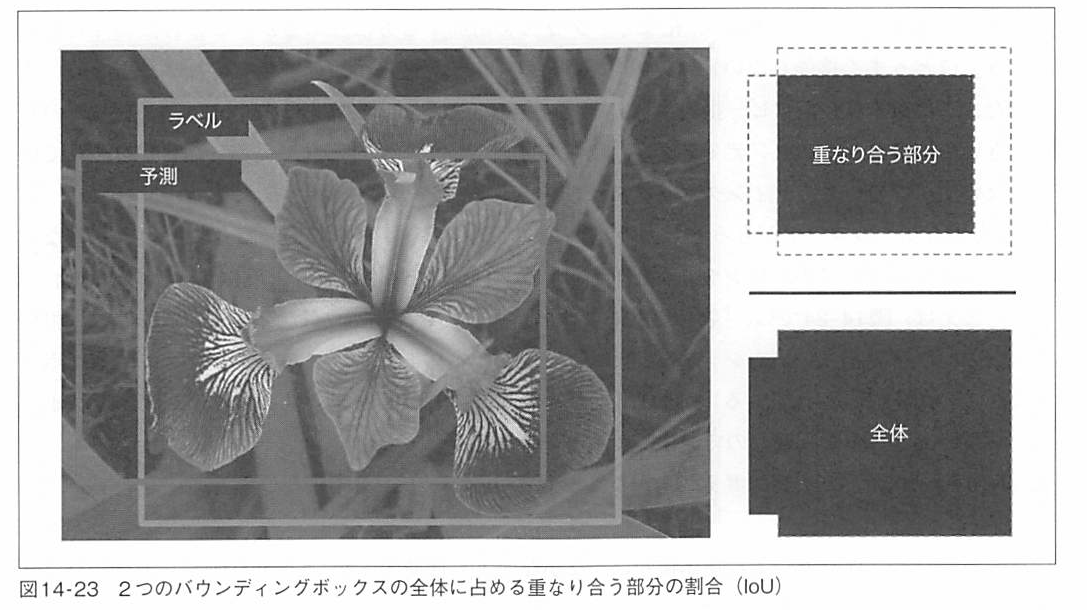

これで1つの物体を分類し、位置を特定する作業はうまくできるようになった。</br>
しかし、画像に複数の物体が含まれている場合にはどうすればよいだろうか?